## Data analysis and simulation activity: Inference in stochastic differential equations - Optical tweezers

### Summary and goals

The goal of this activity is to familiarize with simulation of stochastic differential equations (SDEs) and inference of their parameters from data. We will focus on a specific application: modeling the motion of a microscopic particle trapped in an optical tweezer, which can be described by the overdamped Langevin equation.

A minimal model for characterizing the fluctuations of the position of the trapped particle is the Ornstein-Uhlenbeck model:

$$
\dot{X}_t = -k (X_t-\mu) + D\xi(t)
$$

This equation is obtained in the overdamped limit (ignoring inertia) using the restoring force 
$f(x)=-\nabla V(x)=-k (X_t-\mu)$ and including thermal fluctuations, whose strength is controlled by the diffusion constant $D$.

In the absence of a theory to derive the above equation from first principles, one could try to estimate the constants $k$, $D$, and $\mu$ from data. In class, we have seen two methods to estimate parameters of probabilistic models. The idea is to adapt them to solve this problem. We will first check that the methods are used correctly using them on simulated data where we know the answer, then we will analyze real data.

### Generating synthetic data
The first step is to generate data by integrating the Ornstein–Uhlenbeck model using the Euler–Maruyama method:
$$
X_{t+h} = X_t - k (X_t - \mu)\,h + D\,G(0,h),
$$
where $G(0,h)$ is a Gaussian random variable with zero mean and variance $h$.

1. Simulate and plot many sample paths with $\mu = 1$, $k = 1$, $D = 0.1$, and $X_0=\mu$.

2. From the simulated paths, estimate the propagator, i.e. the transition probability density of finding the process at position $x$ at time $t$ given that it was at $x_0$ at time $0$.
$$
\rho(x)=\lim_{dx\to 0} \frac{1}{dx} P\left(X_t\in[x,x+dx]|X_0=x_0\right).
$$
3. Compare the estimated propagator with its analytical value. For the Ornstein–Uhlenbeck process,
   the propagator over a time step $t$ with initial condition $X_0 = x_0$ is Gaussian:
   $$
   \rho(x)
   = \frac{1}{\sqrt{2\pi\,\sigma_t^2}}
   \exp\left(
     -\frac{\big[x - m_t\big]^2}{2\sigma_t^2}
   \right),
   $$
   where
   $$
   m_t = \mu + (x_0 - \mu)e^{-kt}, \qquad
   \sigma_t^2 = \frac{D^2}{2k}\big(1 - e^{-2kt}\big).
   $$

### Estimate parameters in synthetic data
Using one of our generated trajectories, we now estimate the parameters that were used to generate the data. For the diffusion constant $D$, we use the quadratic variation of the process:
$$
\hat{D}
= \sqrt{\frac{1}{(N-1)\,h}\sum_{i=1}^{N-1} \bigl(x_{(i+1)h}-x_{ih}\bigr)^2 }.
$$

where:

- $h$ is the time step used in the numerical simulation (i.e., the spacing between recorded measurement points).
- $N$ is the total number of sampled time points along the trajectory.
- $x_{ih}$ denotes the position of the process at time $t = i h$, i.e., the value of the recorded trajectory at index $i$.

To estimate $\mu$ we will use the method of moments. Given that $\langle X_t| X_0=\mu\rangle  = \mu$, write and use the estimator $\hat{\mu}$ using the method of moments.

To estimate $k$, we will use the maximum likelihood estimator. Approximating the likelihood of the observed trajectory $\{x_i\}_{i=0}^{N-1}$ with the Euler-Maruyama method, we obtain
$$
L(k) = P(\text{data} \mid k)
\approx \prod_{i=1}^{N-1} 
\frac{1}{\sqrt{2\pi\,\sigma_h^2}}
\exp\left(
  -\frac{\big[x_{i+1} - m_i(k)\big]^2}{2\,\sigma_h^2}
\right),
$$
with
$$
m_i(k) = x_i - k(x_i - \mu) h,
\qquad
\sigma_h^2 = D^2 h.
$$

The maximum likelihood estimator $\hat{k}$ is then obtained by solving
$$
\frac{\partial}{\partial k}  L(k) = 0.
$$
This equation can be solved analytically (it is quadratic in $k$). Find the solution and implement it in a code. *Hint*: It is easier to minimize the log-likelihood, i.e. solve $\frac{\partial}{\partial k} \log \left[L(k)\right] = 0.$.

### Estimate parameters in real data
Once you have verified that the above methodology works on synthetic data, apply it to the experimental position data of the optically trapped particle.

### Genuine research question!!
Now extend the analysis by increasing the complexity of the model:
$$
\dot{X}_t = -k\,(X_t-\mu)^\alpha + D\,\xi(t),
$$
Here, $\mu$, $k$, and $D$ can still be estimated using methods analogous to those used previously. However, estimating the new exponent $\alpha$ introduces a nonlinearity in the restoring force, and the MLE estimation of $\alpha$ requires minimizing the log-likelihood numerically — e.g., using gradient descent or another suitable optimization method. Is $\alpha=1$ or $\alpha\neq 1$?

### Data credit

The experimental position data of the optically trapped particle were obtained from experiments performed by Miguel Ibáñez García (ibanez@ugr.es). Any commercial or research use of these data requires explicit approval from Miguel Ibáñez García and proper attribution to his work:

Ibáñez, M., Dieball, C., Lasanta, A., Godec, A., & Rica, R. A. (2024). Heating and cooling are fundamentally asymmetric and evolve along distinct pathways. Nature Physics, 20(1), 135–141.



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

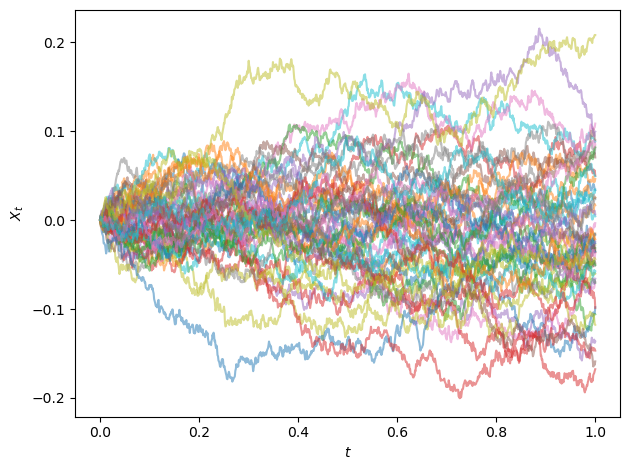

In [16]:
# Example: Simulating Brownian motion (k = 0) and plotting sample paths
D = 0.1          # diffusion coefficient (same D as in your SDE)
x0 = 0.0         # initial condition X_0 = x0
T = 1.0          # final time
dt = 1e-3        # time step
n_steps = int(T / dt)
n_paths = 50   # number of sample paths

# -----------------------------
# 1. Simulate Brownian paths (with Euler–Maruyama)
#    X_{t+h} = X_t + D * G(0, h)
#    with G(0,h) ~ N(0, h) = sqrt(h) * N(0,1)
# -----------------------------
ts = np.linspace(0, T, n_steps + 1)
xs = np.zeros(len(ts))

for ii in range(n_paths):
    x = x0  # Initial condition
    xs[0] = x
    for jj,t in enumerate(ts[1::]):
        dW = np.sqrt(dt) * np.random.normal()  # G(0, dt)
        x += D * dW
        xs[jj+1] = x  # position at time t
    plt.plot(ts, xs, alpha=0.5)


plt.xlabel(r"$t$")
plt.ylabel(r"$X_t$")
plt.tight_layout()
plt.show()


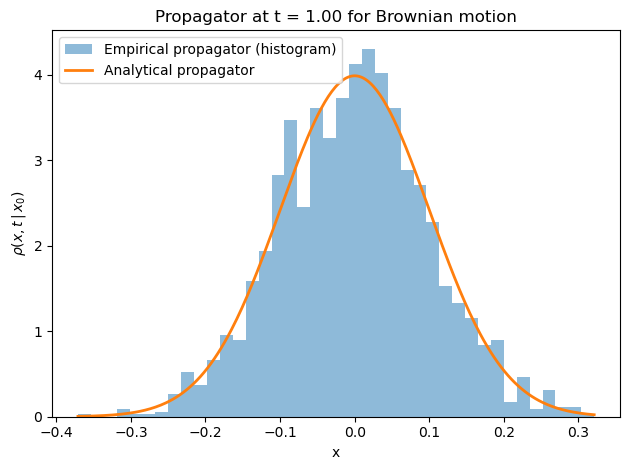

In [17]:
# Example: Simulating Brownian motion (k = 0) and estimating its propagator
D = 0.1          # diffusion coefficient (same D as in your SDE)
x0 = 0.0         # initial condition X_0 = x0
T = 1.0          # final time
dt = 1e-3        # time step
n_steps = int(T / dt)
n_paths = 2000   # number of sample paths

# -----------------------------
# 1. Simulate Brownian paths (with Euler–Maruyama)
#    X_{t+h} = X_t + D * G(0, h)
#    with G(0,h) ~ N(0, h) = sqrt(h) * N(0,1)
# -----------------------------
t = np.linspace(0, T, n_steps + 1)
xfs = np.zeros(n_paths)

for ii in range(n_paths):
    x = x0  # Initial condition
    for n in range(n_steps):
        dW = np.sqrt(dt) * np.random.normal()  # G(0, dt)
        x += D * dW
    xfs[ii] = x  # final position at time T

# -----------------------------
# 2. Estimate the propagator at time T
#    Use the distribution of X_T across paths
# -----------------------------
plt.figure()
plt.hist(
    xfs,
    bins=40,
    density=True,
    alpha=0.5,
    label="Empirical propagator (histogram)"
)

# Analytical propagator for Brownian motion:
# ρ(x, T | x0) = N(x0, D^2 T)
sigma2_t = D**2 * T
sigma_t = np.sqrt(sigma2_t)

x_min, x_max = xfs.min(), xfs.max()
x_plot = np.linspace(x_min, x_max, 300)

rho_analytic = (
    1.0 / np.sqrt(2.0 * np.pi * sigma2_t)
    * np.exp(-(x_plot - x0)**2 / (2.0 * sigma2_t))
)

plt.plot(x_plot, rho_analytic, linewidth=2, label="Analytical propagator")

plt.xlabel("x")
plt.ylabel(r"$\rho(x, t\,|\,x_0)$")
plt.title(f"Propagator at t = {T:.2f} for Brownian motion")
plt.legend()
plt.tight_layout()
plt.show()


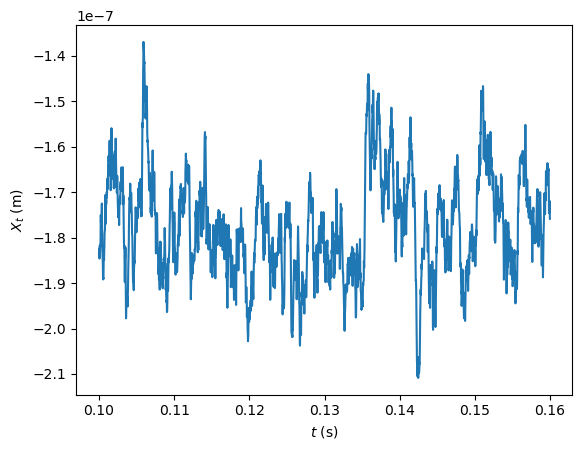

In [20]:
#Real dataset example: Optical tweezer experiment
power= "30" # "12" "20" "30" "sy"
d = pd.read_csv("../Datasets/pw"+power+".out",sep=" ", comment="#",names=["t","x","y","z"])
ts = d["t"].to_numpy()
xs = d["x"].to_numpy()

plt.plot(ts[0:3000],xs[0:3000])
plt.xlabel(r"$t$"+ " (s)")
plt.ylabel(r"$X_t$"+ " (m)")
plt.show();plt.close()